# Assignment 8: Language Modeling With an RNN  
### Requirements  
* Install the Python chakin package, obtain GloVe (and perhaps non-GloVe) embeddings.
* Load and run jump-start code for the assignment, which uses pretrained word vectors from GloVe.6B.50d, a vocabulary of 10,000 words, and movie review data.
* (Optional) Test two or more alternative RNN structures or hyperparameter settings.
* Build and evaluate at least four language models of the experimental design. For each cell in the design, compute classification accuracy in the test set.
* Evaluate the four language models and make recommendations to management.  
  
### Management Problem  
Suppose management is thinking about using a language model to classify written customer reviews and call and complaint logs. If the most critical customer messages can be identified, then customer support personnel can be assigned to contact those customers.

How would you advise senior management? What kinds of systems and methods would be most relevant to the customer services function? Considering the results of this assignment in particular, what is needed to make an automated customer support system that is capable of identifying negative customer feelings? What can data scientists do to make language models more useful in a customer service function?

# Setup & Data Ingest

## Initial Imports

In [0]:
# Imports
import numpy as np
import pandas as pd

import os  # operating system functions
import os.path  # for manipulation of file path names

import re  # regular expressions

from collections import defaultdict

import keras
import tensorflow as tf

import nltk
from nltk.tokenize import TreebankWordTokenizer

In [3]:
# Mount gdrive to load embeddings
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Load Embeddings

In [0]:
# Create file paths to gdrive
RANDOM_SEED = 9999

def reset_graph(seed=RANDOM_SEED):
  '''Makes output stable across runs'''
  tf.reset_default_graph()
  tf.set_random_seed(seed)
  np.random.seed(seed)

# Declare Variables
REMOVE_STOPWORDS = False  # no stopword removal
EVOCABSIZE = 10000  # specify desired size of pre-defined embedding vocabulary

# Select the pre-defined embeddings source
embeddings_dir_one = "/content/gdrive/My Drive/northwestern/422-msds/week-08"
embeddings_dir_two = "run-jump-start-rnn-sentiment-big-v002/embeddings/gloVe.6B"

filename_50 = "glove.6B.50d.txt"
filename_100 = "glove.6B.100d.txt"

embeddings_filename_50 = os.path.join(
    embeddings_dir_one, 
    embeddings_dir_two , 
    filename_50
)

embeddings_filename_100 = os.path.join(
    embeddings_dir_one, 
    embeddings_dir_two , 
    filename_100
)

In [0]:
# Utility function for loading embeddings
# Creates the Python defaultdict dictionary word_to_embedding_dict
# for the requested pre-trained word embeddings
# Note the use of defaultdict data structure from the Python Standard Library
# collections_defaultdict.py lets the caller specify a default value up front
# The default value will be retuned if the key is not a known dictionary key
# That is, unknown words are represented by a vector of zeros
# For word embeddings, this default value is a vector of zeros

def load_embedding_from_disks(embeddings_filename, with_indexes=True):
    """
    Read a embeddings txt file. If `with_indexes=True`,
    we return a tuple of two dictionnaries
    `(word_to_index_dict, index_to_embedding_array)`,
    otherwise we return only a direct
    `word_to_embedding_dict` dictionnary mapping
    from a string to a numpy array.
    """
    if with_indexes:
        word_to_index_dict = dict()
        index_to_embedding_array = []

    else:
        word_to_embedding_dict = dict()

    with open(embeddings_filename, "r", encoding="utf-8") as embeddings_file:
        for (i, line) in enumerate(embeddings_file):

            split = line.split(" ")

            word = split[0]

            representation = split[1:]
            representation = np.array([float(val) for val in representation])

            if with_indexes:
                word_to_index_dict[word] = i
                index_to_embedding_array.append(representation)
            else:
                word_to_embedding_dict[word] = representation

    # Empty representation for unknown words.
    _WORD_NOT_FOUND = [0.0] * len(representation)
    if with_indexes:
        _LAST_INDEX = i + 1
        word_to_index_dict = defaultdict(lambda: _LAST_INDEX, word_to_index_dict)
        index_to_embedding_array = np.array(
            index_to_embedding_array + [_WORD_NOT_FOUND]
        )
        return word_to_index_dict, index_to_embedding_array
    else:
        word_to_embedding_dict = defaultdict(lambda: _WORD_NOT_FOUND)
        return word_to_embedding_dict

In [206]:
# Load embeddings for glove 50
print("Loading embeddings from", embeddings_filename_50)

word_to_index_50, index_to_embedding_50 = load_embedding_from_disks(
    embeddings_filename_50, with_indexes=True
)

print("Embedding loaded from disks.")

Loading embeddings from /content/gdrive/My Drive/northwestern/422-msds/week-08/run-jump-start-rnn-sentiment-big-v002/embeddings/gloVe.6B/glove.6B.50d.txt
Embedding loaded from disks.


In [207]:
# Load embeddings for glove 100
print("Loading embeddings from", embeddings_filename_100)

word_to_index_100, index_to_embedding_100 = load_embedding_from_disks(
    embeddings_filename_100, with_indexes=True
)

print("Embedding loaded from disks.")

Loading embeddings from /content/gdrive/My Drive/northwestern/422-msds/week-08/run-jump-start-rnn-sentiment-big-v002/embeddings/gloVe.6B/glove.6B.100d.txt
Embedding loaded from disks.


# EDA

In [105]:
# Check embedding size/shapes
vocab_size_50, embedding_dim_50 = index_to_embedding_50.shape
print("50 Dimension embedding ---------------------------------------")
print("Embedding is of shape: {}".format(index_to_embedding_50.shape))
print("The first words are words that tend occur more often.\n")

vocab_size_100, embedding_dim_100 = index_to_embedding_100.shape
print("100 Dimension embedding ---------------------------------------")
print("Embedding is of shape: {}".format(index_to_embedding_100.shape))
print("This means (number of words, number of dimensions per word)\n")
print("The first words are words that tend occur more often.")

50 Dimension embedding ---------------------------------------
Embedding is of shape: (400001, 50)
The first words are words that tend occur more often.

100 Dimension embedding ---------------------------------------
Embedding is of shape: (400001, 100)
This means (number of words, number of dimensions per word)

The first words are words that tend occur more often.


In [106]:
# Example representation
print("    {} --> {} --> {}".format("A word", "Index in embedding", "Representation"))

    A word --> Index in embedding --> Representation


In [107]:
# Show how to use embeddings dictionaries with a test sentence
# This is a famous typing exercise with all letters of the alphabet
# https://en.wikipedia.org/wiki/The_quick_brown_fox_jumps_over_the_lazy_dog
a_typing_test_sentence = "The quick brown fox jumps over the lazy dog"
print("\nTest sentence: ", a_typing_test_sentence, "\n")
words_in_test_sentence = a_typing_test_sentence.split()

for word in words_in_test_sentence:
    word_ = word.lower()
    embedding = index_to_embedding_50[word_to_index_50[word_]]
    print(word_ + ": ", embedding)


Test sentence:  The quick brown fox jumps over the lazy dog 

the:  [ 4.1800e-01  2.4968e-01 -4.1242e-01  1.2170e-01  3.4527e-01 -4.4457e-02
 -4.9688e-01 -1.7862e-01 -6.6023e-04 -6.5660e-01  2.7843e-01 -1.4767e-01
 -5.5677e-01  1.4658e-01 -9.5095e-03  1.1658e-02  1.0204e-01 -1.2792e-01
 -8.4430e-01 -1.2181e-01 -1.6801e-02 -3.3279e-01 -1.5520e-01 -2.3131e-01
 -1.9181e-01 -1.8823e+00 -7.6746e-01  9.9051e-02 -4.2125e-01 -1.9526e-01
  4.0071e+00 -1.8594e-01 -5.2287e-01 -3.1681e-01  5.9213e-04  7.4449e-03
  1.7778e-01 -1.5897e-01  1.2041e-02 -5.4223e-02 -2.9871e-01 -1.5749e-01
 -3.4758e-01 -4.5637e-02 -4.4251e-01  1.8785e-01  2.7849e-03 -1.8411e-01
 -1.1514e-01 -7.8581e-01]
quick:  [ 0.13967   -0.53798   -0.18047   -0.25142    0.16203   -0.13868
 -0.24637    0.75111    0.27264    0.61035   -0.82548    0.038647
 -0.32361    0.30373   -0.14598   -0.23551    0.39267   -1.1287
 -0.23636   -1.0629     0.046277   0.29143   -0.25819   -0.094902
  0.79478   -1.2095    -0.01039   -0.092086   0.8432

In [108]:
# Check 100 embeddings
for word in words_in_test_sentence:
    word_ = word.lower()
    embedding = index_to_embedding_100[word_to_index_100[word_]]
    print(word_ + ": ", embedding)

the:  [-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0.28787  -0.06731   0.30906  -0.26384
 -0.13231  -0.20757   0.33395  -0.33848  -0.31743  -0.48336   0.1464
 -0.37304   0.34577   0.052041  0.44946  -0.46971   0.02628  -0.54155
 -0.15518  -0.14107  -0.039722  0.28277   0.14393   0.23464  -0.31021
  0.086173  0.20397   0.52624   0.17164  -0.082378 -0.71787  -0.41531
  0.20335  -0.12763   0.41367   0.55187   0.57908  -0.33477  -0.36559
 -0.54857  -0.062892  0.26584   0.30205   0.99775  -0.80481  -3.0243
  0.01254  -0.36942   2.2167    0.72201  -0.24978   0.92136   0.034514
  0.46745   1.1079   -0.19358  -0.074575  0.23353  -0.052062 -0.22044
  0.057162 -0.15806  -0.30798  -0.41625   0.37972   0.15006  -0.53212
 -0.2055   -1.2526    0.071624  0.70565   0.49744  -0.42063   0.26148
 -1.538    -0.30223  -0.073438 -0.28312   0.37104  -0.25217   0.016215
 -0.017099 -0.38984   0.87424  -0.72569  -0.51058  -0.52028  -0.1459
  0.8278    0.2

# Model Preprocessing

## File Load Preparation

In [0]:
# Define vocabulary size for the language model
# To reduce the size of the vocabulary to the n most frequently used words

def default_factory():
    return EVOCABSIZE  # last/unknown-word row in limited_index_to_embedding


# dictionary has the items() function, returns list of (key, value) tuples
limited_word_to_index_50 = defaultdict(
    default_factory, {k: v for k, v in word_to_index_50.items() if v < EVOCABSIZE}
)

# Select the first EVOCABSIZE rows to the index_to_embedding
limited_index_to_embedding_50 = index_to_embedding_50[0:EVOCABSIZE, :]

# Set the unknown-word row to be all zeros as previously
limited_index_to_embedding_50 = np.append(
    limited_index_to_embedding_50,
    index_to_embedding_50[index_to_embedding_50.shape[0] - 1, :].reshape(1, embedding_dim_50),
    axis=0,
)

# Delete large numpy array to clear some CPU RAM
del index_to_embedding_50

In [0]:
# dictionary has the items() function, returns list of (key, value) tuples
limited_word_to_index_100 = defaultdict(
    default_factory, {k: v for k, v in word_to_index_100.items() if v < EVOCABSIZE}
)

# Select the first EVOCABSIZE rows to the index_to_embedding
limited_index_to_embedding_100 = index_to_embedding_100[0:EVOCABSIZE, :]

# Set the unknown-word row to be all zeros as previously
limited_index_to_embedding_100 = np.append(
    limited_index_to_embedding_100,
    index_to_embedding_100[index_to_embedding_100.shape[0] - 1, :].reshape(1, embedding_dim_100),
    axis=0,
)

# Delete large numpy array to clear some CPU RAM
del index_to_embedding_100

In [0]:
# ------------------------------------------------------------
# code for working with movie reviews data
# Source: Miller, T. W. (2016). Web and Network Data Science.
#    Upper Saddle River, N.J.: Pearson Education.
#    ISBN-13: 978-0-13-388644-3
# This original study used a simple bag-of-words approach
# to sentiment analysis, along with pre-defined lists of
# negative and positive words.
# Code available at:  https://github.com/mtpa/wnds
# ------------------------------------------------------------
# Utility function to get file names within a directory
def listdir_no_hidden(path):
    start_list = os.listdir(path)
    end_list = []
    for file in start_list:
        if not file.startswith("."):
            end_list.append(file)
    return end_list


# define list of codes to be dropped from document
# carriage-returns, line-feeds, tabs
codelist = ["\r", "\n", "\t"]

In [0]:
# We will not remove stopwords in this exercise because they are
# important to keeping sentences intact
if REMOVE_STOPWORDS:
    print(nltk.corpus.stopwords.words("english"))

    # previous analysis of a list of top terms showed a number of words, along
    # with contractions and other word strings to drop from further analysis, add
    # these to the usual English stopwords to be dropped from a document collection
    more_stop_words = [
        "cant",
        "didnt",
        "doesnt",
        "dont",
        "goes",
        "isnt",
        "hes",
        "shes",
        "thats",
        "theres",
        "theyre",
        "wont",
        "youll",
        "youre",
        "youve",
        "br" "ve",
        "re",
        "vs",
    ]

    some_proper_nouns_to_remove = [
        "dick",
        "ginger",
        "hollywood",
        "jack",
        "jill",
        "john",
        "karloff",
        "kudrow",
        "orson",
        "peter",
        "tcm",
        "tom",
        "toni",
        "welles",
        "william",
        "wolheim",
        "nikita",
    ]

    # start with the initial list and add to it for movie text work
    stoplist = (
        nltk.corpus.stopwords.words("english")
        + more_stop_words
        + some_proper_nouns_to_remove
    )

In [0]:
# text parsing function for creating text documents
# there is more we could do for data preparation
# stemming... looking for contractions... possessives...
# but we will work with what we have in this parsing function
# if we want to do stemming at a later time, we can use
#     porter = nltk.PorterStemmer()
# in a construction like this
#     words_stemmed =  [porter.stem(word) for word in initial_words]
def text_parse(string):
    # replace non-alphanumeric with space
    temp_string = re.sub("[^a-zA-Z]", "  ", string)
    # replace codes with space
    for i in range(len(codelist)):
        stopstring = " " + codelist[i] + "  "
        temp_string = re.sub(stopstring, "  ", temp_string)
    # replace single-character words with space
    temp_string = re.sub("\s.\s", " ", temp_string)
    # convert uppercase to lowercase
    temp_string = temp_string.lower()
    if REMOVE_STOPWORDS:
        # replace selected character strings/stop-words with space
        for i in range(len(stoplist)):
            stopstring = " " + str(stoplist[i]) + " "
            temp_string = re.sub(stopstring, " ", temp_string)
    # replace multiple blank characters with one blank character
    temp_string = re.sub("\s+", " ", temp_string)
    return temp_string

## Load Review Data

In [219]:
# -----------------------------------------------
# gather data for 500 negative movie reviews
# -----------------------------------------------
dir_name = os.path.join(
    embeddings_dir_one, 
    "run-jump-start-rnn-sentiment-big-v002/movie-reviews-negative"
)

filenames = listdir_no_hidden(path=dir_name)
num_files = len(filenames)

for i in range(len(filenames)):
    file_exists = os.path.isfile(os.path.join(dir_name, filenames[i]))
    assert file_exists
print("\nDirectory:", dir_name)
print("%d files found" % len(filenames))


Directory: /content/gdrive/My Drive/northwestern/422-msds/week-08/run-jump-start-rnn-sentiment-big-v002/movie-reviews-negative
500 files found


In [220]:
# Read data for negative movie reviews
# Data will be stored in a list of lists where the each list represents
# a document and document is a list of words.
# We then break the text into words.


def read_data(filename):

    with open(filename, encoding="utf-8") as f:
        data = tf.compat.as_str(f.read())
        data = data.lower()
        data = text_parse(data)
        data = TreebankWordTokenizer().tokenize(data)  # The Penn Treebank

    return data


negative_documents = []

print("\nProcessing document files under", dir_name)
for i in range(num_files):
    ## print(' ', filenames[i])

    words = read_data(os.path.join(dir_name, filenames[i]))

    negative_documents.append(words)
    # print('Data size (Characters) (Document %d) %d' %(i,len(words)))
    # print('Sample string (Document %d) %s'%(i,words[:50]))


Processing document files under /content/gdrive/My Drive/northwestern/422-msds/week-08/run-jump-start-rnn-sentiment-big-v002/movie-reviews-negative


In [221]:
# -----------------------------------------------
# gather data for 500 positive movie reviews
# -----------------------------------------------
dir_name = os.path.join(
    embeddings_dir_one, 
    "run-jump-start-rnn-sentiment-big-v002/movie-reviews-positive"
)

filenames = listdir_no_hidden(path=dir_name)
num_files = len(filenames)

for i in range(len(filenames)):
    file_exists = os.path.isfile(os.path.join(dir_name, filenames[i]))
    assert file_exists
print("\nDirectory:", dir_name)
print("%d files found" % len(filenames))


Directory: /content/gdrive/My Drive/northwestern/422-msds/week-08/run-jump-start-rnn-sentiment-big-v002/movie-reviews-positive
500 files found


In [222]:
# Read data for positive movie reviews
# Data will be stored in a list of lists where the each list
# represents a document and document is a list of words.
# We then break the text into words.

positive_documents = []

print("\nProcessing document files under", dir_name)
for i in range(num_files):
    ## print(' ', filenames[i])

    words = read_data(os.path.join(dir_name, filenames[i]))

    positive_documents.append(words)
    
print("\nProcessing Complete!")


Processing document files under /content/gdrive/My Drive/northwestern/422-msds/week-08/run-jump-start-rnn-sentiment-big-v002/movie-reviews-positive

Processing Complete!


In [223]:
len(negative_documents[0])

219

## Process Dataset

In [224]:
# -----------------------------------------------------
# convert positive/negative documents into numpy array
# note that reviews vary from 22 to 1052 words
# so we use the first 20 and last 20 words of each review
# as our word sequences for analysis
# -----------------------------------------------------
max_review_length = 0  # initialize
for doc in negative_documents:
    max_review_length = max(max_review_length, len(doc))
for doc in positive_documents:
    max_review_length = max(max_review_length, len(doc))
print("max_review_length:", max_review_length)

min_review_length = max_review_length  # initialize
for doc in negative_documents:
    min_review_length = min(min_review_length, len(doc))
for doc in positive_documents:
    min_review_length = min(min_review_length, len(doc))
print("min_review_length:", min_review_length)

max_review_length: 1052
min_review_length: 22


In [0]:
# construct list of 1000 lists with 40 words in each list
from itertools import chain

documents = []

for doc in negative_documents:
    doc_begin = doc[0:20]
    doc_end = doc[len(doc) - 20 : len(doc)]
    documents.append(list(chain(*[doc_begin, doc_end])))
    
for doc in positive_documents:
    doc_begin = doc[0:20]
    doc_end = doc[len(doc) - 20 : len(doc)]
    documents.append(list(chain(*[doc_begin, doc_end])))

In [226]:
len(documents[0])

40

In [0]:
# create list of lists of lists for embeddings
embeddings_50 = []

for doc in documents:
    embedding = []
    for word in doc:
        embedding.append(limited_index_to_embedding_50[limited_word_to_index_50[word]])
    embeddings_50.append(embedding)

In [0]:
# create list of lists of lists for embeddings
embeddings_100 = []

for doc in documents:
    embedding = []
    for word in doc:
        embedding.append(limited_index_to_embedding_100[limited_word_to_index_100[word]])
    embeddings_100.append(embedding)

In [249]:
# -----------------------------------------------------
# Check on the embeddings list of list of lists
# -----------------------------------------------------
# Show the first word in the first document
test_word = documents[0][0]
print("First word in first document:", test_word)
print(
    "Embedding for this word:\n",
    limited_index_to_embedding_50[limited_word_to_index_50[test_word]],
)
print(
    "Corresponding embedding from embeddings list of list of lists\n",
    embeddings_50[0][0][:],
)

First word in first document: this
Embedding for this word:
 [ 5.3074e-01  4.0117e-01 -4.0785e-01  1.5444e-01  4.7782e-01  2.0754e-01
 -2.6951e-01 -3.4023e-01 -1.0879e-01  1.0563e-01 -1.0289e-01  1.0849e-01
 -4.9681e-01 -2.5128e-01  8.4025e-01  3.8949e-01  3.2284e-01 -2.2797e-01
 -4.4342e-01 -3.1649e-01 -1.2406e-01 -2.8170e-01  1.9467e-01  5.5513e-02
  5.6705e-01 -1.7419e+00 -9.1145e-01  2.7036e-01  4.1927e-01  2.0279e-02
  4.0405e+00 -2.4943e-01 -2.0416e-01 -6.2762e-01 -5.4783e-02 -2.6883e-01
  1.8444e-01  1.8204e-01 -2.3536e-01 -1.6155e-01 -2.7655e-01  3.5506e-02
 -3.8211e-01 -7.5134e-04 -2.4822e-01  2.8164e-01  1.2819e-01  2.8762e-01
  1.4440e-01  2.3611e-01]
Corresponding embedding from embeddings list of list of lists
 [ 5.3074e-01  4.0117e-01 -4.0785e-01  1.5444e-01  4.7782e-01  2.0754e-01
 -2.6951e-01 -3.4023e-01 -1.0879e-01  1.0563e-01 -1.0289e-01  1.0849e-01
 -4.9681e-01 -2.5128e-01  8.4025e-01  3.8949e-01  3.2284e-01 -2.2797e-01
 -4.4342e-01 -3.1649e-01 -1.2406e-01 -2.8170e-0

In [0]:
# -----------------------------------------------------
# Make embeddings a numpy array for use in an RNN
# Create training and test sets with Scikit Learn
# -----------------------------------------------------
embeddings_array_50 = np.array(embeddings_50)

# Define the labels to be used 500 negative (0) and 500 positive (1)
thumbs_down_up = np.concatenate(
    (np.zeros((500), dtype=np.int32), np.ones((500), dtype=np.int32)), axis=0
)

In [0]:
embeddings_array_100 = np.array(embeddings_100)

In [289]:
# Review the shape
print(embeddings_array_50.shape)
print(embeddings_array_100.shape)

(1000, 40, 50)
(1000, 40, 100)


In [237]:
# Labels shape
thumbs_down_up.shape

(1000,)

# Modeling

## Train Test Split

In [0]:
# Scikit Learn for random splitting of the data
from sklearn.model_selection import train_test_split

# Random splitting of the data in to training (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    embeddings_array_50, thumbs_down_up, test_size=0.20, random_state=RANDOM_SEED
)

In [0]:
# Split the 100 embeddings
# Random splitting of the data in to training (80%) and test (20%)
X_train_100, X_test_100, y_train_100, y_test_100 = train_test_split(
    embeddings_array_100, thumbs_down_up, test_size=0.20, random_state=RANDOM_SEED
)

In [291]:
print(X_train.shape)
print(X_train_100.shape)

(800, 40, 50)
(800, 40, 100)


## Model 1:  
* 20 Neurons
* 50 dimensions of pre-trained embeddings
* 50 epochs
* 100 batch size

In [279]:
# Build Model
reset_graph()

n_steps = embeddings_array_50.shape[1]  # number of words per document
n_inputs = embeddings_array_50.shape[2]  # dimension of  pre-trained embeddings
n_neurons = 20  # analyst specified number of neurons
n_outputs = 2  # thumbs-down or thumbs-up

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

n_epochs = 50
batch_size = 100

with tf.Session() as sess:
    init.run()
    print("Start of Training: Embeddings = 50")
    epochs = []
    train_acc = []
    test_acc = []
    for epoch in range(n_epochs):
        print("\n  ---- Epoch ", epoch + 1, " ----")
        epochs.append(epoch + 1)
        for iteration in range(y_train.shape[0] // batch_size):
            X_batch = X_train[iteration * batch_size : (iteration + 1) * batch_size, :]
            y_batch = y_train[iteration * batch_size : (iteration + 1) * batch_size]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("Train accuracy:", acc_train, "Test accuracy:", acc_test)
        train_acc.append(acc_train)
        test_acc.append(acc_test)
    print("End of Training")

Start of Training: Embeddings = 50

  ---- Epoch  1  ----
Train accuracy: 0.58 Test accuracy: 0.465

  ---- Epoch  2  ----
Train accuracy: 0.55 Test accuracy: 0.495

  ---- Epoch  3  ----
Train accuracy: 0.6 Test accuracy: 0.49

  ---- Epoch  4  ----
Train accuracy: 0.55 Test accuracy: 0.505

  ---- Epoch  5  ----
Train accuracy: 0.54 Test accuracy: 0.5

  ---- Epoch  6  ----
Train accuracy: 0.58 Test accuracy: 0.495

  ---- Epoch  7  ----
Train accuracy: 0.57 Test accuracy: 0.53

  ---- Epoch  8  ----
Train accuracy: 0.58 Test accuracy: 0.52

  ---- Epoch  9  ----
Train accuracy: 0.59 Test accuracy: 0.53

  ---- Epoch  10  ----
Train accuracy: 0.61 Test accuracy: 0.535

  ---- Epoch  11  ----
Train accuracy: 0.6 Test accuracy: 0.54

  ---- Epoch  12  ----
Train accuracy: 0.59 Test accuracy: 0.555

  ---- Epoch  13  ----
Train accuracy: 0.59 Test accuracy: 0.565

  ---- Epoch  14  ----
Train accuracy: 0.6 Test accuracy: 0.56

  ---- Epoch  15  ----
Train accuracy: 0.61 Test accuracy: 0

In [0]:
# Save off the data for comparison dataframe
model_one = {
    "epochs": epochs[-1],
    "train_acc": train_acc[-1],
    "test_acc": test_acc[-1],
    "neurons": n_neurons
}

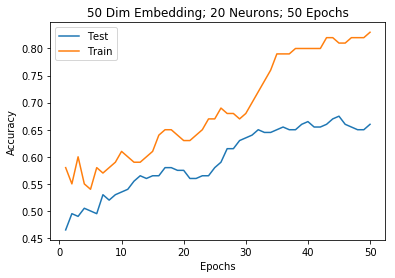

In [281]:
import matplotlib.pyplot as plt

plt.plot(epochs, test_acc)
plt.plot(epochs, train_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("50 Dim Embedding; 20 Neurons; 50 Epochs")
plt.legend(["Test", "Train"])

## Model 2:  
* 30 Neurons  
* 50 dimensions of pre-trained embeddings
* 25 epochs  
* 100 batch size

In [282]:
# Build the model
reset_graph()

n_steps = embeddings_array_50.shape[1]  # number of words per document
n_inputs = embeddings_array_50.shape[2]  # dimension of  pre-trained embeddings
n_neurons = 30  # analyst specified number of neurons
n_outputs = 2  # thumbs-down or thumbs-up

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

n_epochs = 25
batch_size = 100

with tf.Session() as sess:
    init.run()
    print("Start of Training: Embeddings = 50")
    epochs = []
    train_acc = []
    test_acc = []
    for epoch in range(n_epochs):
        print("\n  ---- Epoch ", epoch + 1, " ----")
        epochs.append(epoch + 1)
        for iteration in range(y_train.shape[0] // batch_size):
            X_batch = X_train[iteration * batch_size : (iteration + 1) * batch_size, :]
            y_batch = y_train[iteration * batch_size : (iteration + 1) * batch_size]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("Train accuracy:", acc_train, "Test accuracy:", acc_test)
        train_acc.append(acc_train)
        test_acc.append(acc_test)
    print("End of Training")

Start of Training: Embeddings = 50

  ---- Epoch  1  ----
Train accuracy: 0.44 Test accuracy: 0.465

  ---- Epoch  2  ----
Train accuracy: 0.51 Test accuracy: 0.465

  ---- Epoch  3  ----
Train accuracy: 0.54 Test accuracy: 0.51

  ---- Epoch  4  ----
Train accuracy: 0.56 Test accuracy: 0.515

  ---- Epoch  5  ----
Train accuracy: 0.57 Test accuracy: 0.495

  ---- Epoch  6  ----
Train accuracy: 0.58 Test accuracy: 0.535

  ---- Epoch  7  ----
Train accuracy: 0.61 Test accuracy: 0.545

  ---- Epoch  8  ----
Train accuracy: 0.59 Test accuracy: 0.55

  ---- Epoch  9  ----
Train accuracy: 0.58 Test accuracy: 0.54

  ---- Epoch  10  ----
Train accuracy: 0.62 Test accuracy: 0.53

  ---- Epoch  11  ----
Train accuracy: 0.61 Test accuracy: 0.525

  ---- Epoch  12  ----
Train accuracy: 0.64 Test accuracy: 0.53

  ---- Epoch  13  ----
Train accuracy: 0.65 Test accuracy: 0.545

  ---- Epoch  14  ----
Train accuracy: 0.67 Test accuracy: 0.555

  ---- Epoch  15  ----
Train accuracy: 0.66 Test accur

In [0]:
# Save off the data for comparison dataframe
model_two = {
    "epochs": epochs[-1],
    "train_acc": train_acc[-1],
    "test_acc": test_acc[-1],
    "neurons": n_neurons
}

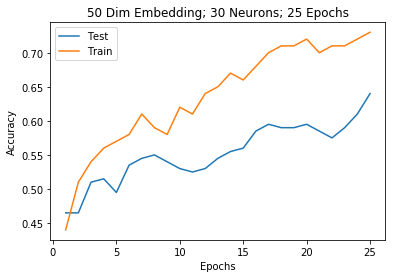

In [284]:
plt.plot(epochs, test_acc)
plt.plot(epochs, train_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("50 Dim Embedding; 30 Neurons; 25 Epochs")
plt.legend(["Test", "Train"])

## Model 3:  
* 20 neurons
* 100 dimensions of pre-trained embeddings
* 50 epochs
* 100 batch size

In [292]:
# Build the model
reset_graph()

n_steps = embeddings_array_100.shape[1]  # number of words per document
n_inputs = embeddings_array_100.shape[2]  # dimension of  pre-trained embeddings
n_neurons = 20  # analyst specified number of neurons
n_outputs = 2  # thumbs-down or thumbs-up

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

n_epochs = 50
batch_size = 100

with tf.Session() as sess:
    init.run()
    print("Start of Training: Embeddings = 50")
    epochs = []
    train_acc = []
    test_acc = []
    for epoch in range(n_epochs):
        print("\n  ---- Epoch ", epoch + 1, " ----")
        epochs.append(epoch + 1)
        for iteration in range(y_train.shape[0] // batch_size):
            X_batch = X_train_100[iteration * batch_size : (iteration + 1) * batch_size, :]
            y_batch = y_train_100[iteration * batch_size : (iteration + 1) * batch_size]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test_100, y: y_test_100})
        print("Train accuracy:", acc_train, "Test accuracy:", acc_test)
        train_acc.append(acc_train)
        test_acc.append(acc_test)
    print("End of Training")

Start of Training: Embeddings = 50

  ---- Epoch  1  ----
Train accuracy: 0.49 Test accuracy: 0.515

  ---- Epoch  2  ----
Train accuracy: 0.55 Test accuracy: 0.555

  ---- Epoch  3  ----
Train accuracy: 0.56 Test accuracy: 0.57

  ---- Epoch  4  ----
Train accuracy: 0.6 Test accuracy: 0.575

  ---- Epoch  5  ----
Train accuracy: 0.6 Test accuracy: 0.565

  ---- Epoch  6  ----
Train accuracy: 0.64 Test accuracy: 0.57

  ---- Epoch  7  ----
Train accuracy: 0.65 Test accuracy: 0.57

  ---- Epoch  8  ----
Train accuracy: 0.67 Test accuracy: 0.575

  ---- Epoch  9  ----
Train accuracy: 0.67 Test accuracy: 0.575

  ---- Epoch  10  ----
Train accuracy: 0.67 Test accuracy: 0.57

  ---- Epoch  11  ----
Train accuracy: 0.67 Test accuracy: 0.575

  ---- Epoch  12  ----
Train accuracy: 0.67 Test accuracy: 0.575

  ---- Epoch  13  ----
Train accuracy: 0.67 Test accuracy: 0.575

  ---- Epoch  14  ----
Train accuracy: 0.67 Test accuracy: 0.58

  ---- Epoch  15  ----
Train accuracy: 0.69 Test accurac

In [0]:
# Save off the data for comparison dataframe
model_three = {
    "epochs": epochs[-1],
    "train_acc": train_acc[-1],
    "test_acc": test_acc[-1],
    "neurons": n_neurons
}

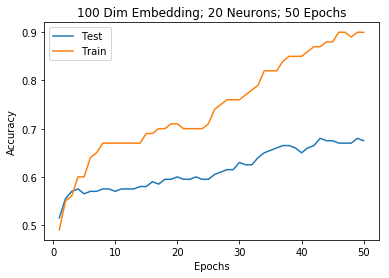

In [294]:
plt.plot(epochs, test_acc)
plt.plot(epochs, train_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("100 Dim Embedding; 20 Neurons; 50 Epochs")
plt.legend(["Test", "Train"])

## Model 4:  
* 30 Neurons  
* 100 dimensions of pre-trained embeddings
* 25 epochs  
* 100 batch size

In [295]:
# Build the model
reset_graph()

n_steps = embeddings_array_100.shape[1]  # number of words per document
n_inputs = embeddings_array_100.shape[2]  # dimension of  pre-trained embeddings
n_neurons = 30  # analyst specified number of neurons
n_outputs = 2  # thumbs-down or thumbs-up

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

n_epochs = 25
batch_size = 100

with tf.Session() as sess:
    init.run()
    print("Start of Training: Embeddings = 50")
    epochs = []
    train_acc = []
    test_acc = []
    for epoch in range(n_epochs):
        print("\n  ---- Epoch ", epoch + 1, " ----")
        epochs.append(epoch + 1)
        for iteration in range(y_train.shape[0] // batch_size):
            X_batch = X_train_100[iteration * batch_size : (iteration + 1) * batch_size, :]
            y_batch = y_train_100[iteration * batch_size : (iteration + 1) * batch_size]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test_100, y: y_test_100})
        print("Train accuracy:", acc_train, "Test accuracy:", acc_test)
        train_acc.append(acc_train)
        test_acc.append(acc_test)
    print("End of Training")

Start of Training: Embeddings = 50

  ---- Epoch  1  ----
Train accuracy: 0.61 Test accuracy: 0.53

  ---- Epoch  2  ----
Train accuracy: 0.61 Test accuracy: 0.525

  ---- Epoch  3  ----
Train accuracy: 0.63 Test accuracy: 0.565

  ---- Epoch  4  ----
Train accuracy: 0.61 Test accuracy: 0.575

  ---- Epoch  5  ----
Train accuracy: 0.62 Test accuracy: 0.595

  ---- Epoch  6  ----
Train accuracy: 0.64 Test accuracy: 0.59

  ---- Epoch  7  ----
Train accuracy: 0.64 Test accuracy: 0.585

  ---- Epoch  8  ----
Train accuracy: 0.64 Test accuracy: 0.595

  ---- Epoch  9  ----
Train accuracy: 0.64 Test accuracy: 0.6

  ---- Epoch  10  ----
Train accuracy: 0.64 Test accuracy: 0.64

  ---- Epoch  11  ----
Train accuracy: 0.63 Test accuracy: 0.67

  ---- Epoch  12  ----
Train accuracy: 0.62 Test accuracy: 0.665

  ---- Epoch  13  ----
Train accuracy: 0.67 Test accuracy: 0.695

  ---- Epoch  14  ----
Train accuracy: 0.66 Test accuracy: 0.7

  ---- Epoch  15  ----
Train accuracy: 0.68 Test accuracy

In [0]:
# Save off the data for comparison dataframe
model_four = {
    "epochs": epochs[-1],
    "train_acc": train_acc[-1],
    "test_acc": test_acc[-1],
    "neurons": n_neurons
}

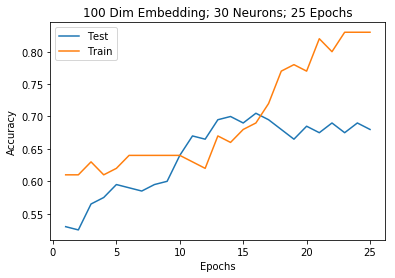

In [297]:
plt.plot(epochs, test_acc)
plt.plot(epochs, train_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("100 Dim Embedding; 30 Neurons; 25 Epochs")
plt.legend(["Test", "Train"])

## Model 5:  
* 30 Neurons
* 100 dimensions of pre-trained embeddings
* 100 epochs
* 100 batch size

In [299]:
# Build the model
reset_graph()

n_steps = embeddings_array_100.shape[1]  # number of words per document
n_inputs = embeddings_array_100.shape[2]  # dimension of  pre-trained embeddings
n_neurons = 20  # analyst specified number of neurons
n_outputs = 2  # thumbs-down or thumbs-up

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

n_epochs = 100
batch_size = 100

with tf.Session() as sess:
    init.run()
    print("Start of Training: Embeddings = 50")
    epochs = []
    train_acc = []
    test_acc = []
    for epoch in range(n_epochs):
        print("\n  ---- Epoch ", epoch + 1, " ----")
        epochs.append(epoch + 1)
        for iteration in range(y_train.shape[0] // batch_size):
            X_batch = X_train_100[iteration * batch_size : (iteration + 1) * batch_size, :]
            y_batch = y_train_100[iteration * batch_size : (iteration + 1) * batch_size]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test_100, y: y_test_100})
        print("Train accuracy:", acc_train, "Test accuracy:", acc_test)
        train_acc.append(acc_train)
        test_acc.append(acc_test)
    print("End of Training")

Start of Training: Embeddings = 50

  ---- Epoch  1  ----
Train accuracy: 0.49 Test accuracy: 0.515

  ---- Epoch  2  ----
Train accuracy: 0.55 Test accuracy: 0.555

  ---- Epoch  3  ----
Train accuracy: 0.56 Test accuracy: 0.57

  ---- Epoch  4  ----
Train accuracy: 0.6 Test accuracy: 0.575

  ---- Epoch  5  ----
Train accuracy: 0.6 Test accuracy: 0.565

  ---- Epoch  6  ----
Train accuracy: 0.64 Test accuracy: 0.57

  ---- Epoch  7  ----
Train accuracy: 0.65 Test accuracy: 0.57

  ---- Epoch  8  ----
Train accuracy: 0.67 Test accuracy: 0.575

  ---- Epoch  9  ----
Train accuracy: 0.67 Test accuracy: 0.575

  ---- Epoch  10  ----
Train accuracy: 0.67 Test accuracy: 0.57

  ---- Epoch  11  ----
Train accuracy: 0.67 Test accuracy: 0.575

  ---- Epoch  12  ----
Train accuracy: 0.67 Test accuracy: 0.575

  ---- Epoch  13  ----
Train accuracy: 0.67 Test accuracy: 0.575

  ---- Epoch  14  ----
Train accuracy: 0.67 Test accuracy: 0.58

  ---- Epoch  15  ----
Train accuracy: 0.69 Test accurac

In [0]:
# Save off the data for comparison dataframe
model_five = {
    "epochs": epochs[-1],
    "train_acc": train_acc[-1],
    "test_acc": test_acc[-1],
    "neurons": n_neurons
}

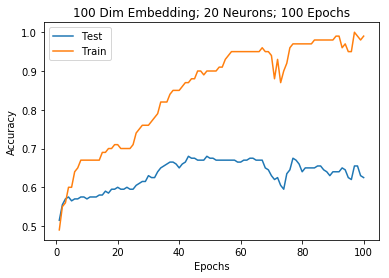

In [301]:
plt.plot(epochs, test_acc)
plt.plot(epochs, train_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("100 Dim Embedding; 20 Neurons; 100 Epochs")
plt.legend(["Test", "Train"])

## Summary

In [311]:
summary_df = pd.DataFrame(
    [
        model_one, 
        model_two,
        model_three,
        model_four,
        model_five
    ], 
    index=["Model_One", "Model_Two", "Model_Three", 
           "Model_Four", "Model_Five"]
)

summary_df

,epochs,neurons,test_acc,train_acc
Model_One,50,20,0.660,0.83
Model_Two,25,30,0.640,0.73
Model_Three,50,20,0.675,0.90
Model_Four,25,30,0.680,0.83
Model_Five,100,20,0.625,0.99


Text(0, 0.5, 'Test Accuracy')

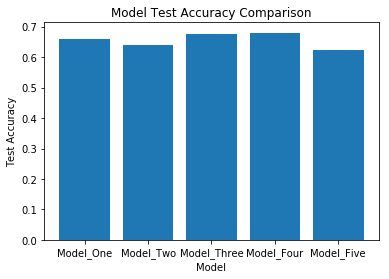

In [314]:
plt.bar(summary_df.index, summary_df["test_acc"])
plt.title("Model Test Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Test Accuracy")

# Conclusion  
Management should consider utilizing a natural language classification model that predicts the sentiment of a customer review.  The RNN architecture yields itself to this particular problem.  In order for an automated customer support solution to be implemented, a couple things would be needed.  First, a model achieving a higher accuracy would be necessary. The models tested in this analysis didn't perform above 70% accuracy on the test data.  Further experimentation with layer architechture would be needed. Second, the model would need to be wrapped in an API so that it could server sentiment predictions on customer reviews as they came in.  A pre-processing pipeline would have to be setup for reviews so that they were in the correct format for the model to make predictions.